In [1]:
# imports for notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [99]:
# read in the dates and their recorded unique characteristics
dates = pd.read_csv('C:/Users/TWood/Downloads/m5-forecasting-accuracy/calendar.csv', parse_dates=[0])

In [100]:
dates.drop(columns=['weekday', 'year', 'event_type_1', 'event_type_2', 'snap_TX', 'snap_WI'], inplace=True)

In [101]:
dates.replace(np.NaN, 'None', inplace=True)

In [102]:
# read in the training data
val = pd.read_csv('C:/Users/TWood/Downloads/m5-forecasting-accuracy/sales_train_validation.csv')

In [103]:
val['dept_id'].unique()

array(['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1',
       'FOODS_2', 'FOODS_3'], dtype=object)

In [104]:
CA1_f2 = val[(val['store_id'] == 'CA_1')&(val['dept_id'] == 'HOBBIES_1')]

In [105]:
CA1_f2_melt = CA1_f2.drop(columns=['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'])

In [106]:
CA1_f2_ts = CA1_f2_melt.melt(id_vars=['id'], var_name='d', value_name='sales')

In [107]:
CA1_f2_ts

,id,d,sales
0,HOBBIES_1_001_CA_1_validation,d_1,0
1,HOBBIES_1_002_CA_1_validation,d_1,0
2,HOBBIES_1_003_CA_1_validation,d_1,0
3,HOBBIES_1_004_CA_1_validation,d_1,0
4,HOBBIES_1_005_CA_1_validation,d_1,0
...,...,...,...
795803,HOBBIES_1_420_CA_1_validation,d_1913,0
795804,HOBBIES_1_421_CA_1_validation,d_1913,1
795805,HOBBIES_1_422_CA_1_validation,d_1913,0
795806,HOBBIES_1_423_CA_1_validation,d_1913,2


In [108]:
CA1_f2_ts = CA1_f2_ts.merge(dates, how='inner', on='d')

In [109]:
CA1_f2_ts

,id,d,sales,date,wm_yr_wk,wday,month,event_name_1,event_name_2,snap_CA
0,HOBBIES_1_001_CA_1_validation,d_1,0,2011-01-29,11101,1,1,None,None,0
1,HOBBIES_1_002_CA_1_validation,d_1,0,2011-01-29,11101,1,1,None,None,0
2,HOBBIES_1_003_CA_1_validation,d_1,0,2011-01-29,11101,1,1,None,None,0
3,HOBBIES_1_004_CA_1_validation,d_1,0,2011-01-29,11101,1,1,None,None,0
4,HOBBIES_1_005_CA_1_validation,d_1,0,2011-01-29,11101,1,1,None,None,0
...,...,...,...,...,...,...,...,...,...,...
795803,HOBBIES_1_420_CA_1_validation,d_1913,0,2016-04-24,11613,2,4,None,None,0
795804,HOBBIES_1_421_CA_1_validation,d_1913,1,2016-04-24,11613,2,4,None,None,0
795805,HOBBIES_1_422_CA_1_validation,d_1913,0,2016-04-24,11613,2,4,None,None,0
795806,HOBBIES_1_423_CA_1_validation,d_1913,2,2016-04-24,11613,2,4,None,None,0


In [110]:
CA1_f2_ts.set_index('date', inplace=True)

In [111]:
CA1_f2_ts.loc['2011-01-30']

,id,d,sales,wm_yr_wk,wday,month,event_name_1,event_name_2,snap_CA
date,,,,,,,,,
2011-01-30,HOBBIES_1_001_CA_1_validation,d_2,0,11101,2,1,None,None,0
2011-01-30,HOBBIES_1_002_CA_1_validation,d_2,0,11101,2,1,None,None,0
2011-01-30,HOBBIES_1_003_CA_1_validation,d_2,0,11101,2,1,None,None,0
2011-01-30,HOBBIES_1_004_CA_1_validation,d_2,0,11101,2,1,None,None,0
2011-01-30,HOBBIES_1_005_CA_1_validation,d_2,0,11101,2,1,None,None,0
...,...,...,...,...,...,...,...,...,...
2011-01-30,HOBBIES_1_420_CA_1_validation,d_2,3,11101,2,1,None,None,0
2011-01-30,HOBBIES_1_421_CA_1_validation,d_2,0,11101,2,1,None,None,0
2011-01-30,HOBBIES_1_422_CA_1_validation,d_2,0,11101,2,1,None,None,0


In [112]:
CA1_f2_ts['lag_1'] = CA1_f2_ts['sales'].shift(periods=416)

In [113]:
CA1_f2_ts['lag_2'] = CA1_f2_ts['sales'].shift(periods=(416*2))

In [114]:
CA1_f2_ts['lag_3'] = CA1_f2_ts['sales'].shift(periods=(416*3))

In [115]:
CA1_f2_ts['lag_4'] = CA1_f2_ts['sales'].shift(periods=(416*4))

In [116]:
CA1_f2_ts['lag_5'] = CA1_f2_ts['sales'].shift(periods=(416*5))

In [117]:
CA1_f2_ts['lag_6'] = CA1_f2_ts['sales'].shift(periods=(416*6))

In [118]:
CA1_f2_ts['lag_7'] = CA1_f2_ts['sales'].shift(periods=(416*7))

In [119]:
CA1_f2_ts['lag_14'] = CA1_f2_ts['sales'].shift(periods=(416*14))

In [120]:
CA1_f2_ts['lag_21'] = CA1_f2_ts['sales'].shift(periods=(416*21))

In [121]:
CA1_f2_ts['lag_28'] = CA1_f2_ts['sales'].shift(periods=(416*28))

In [122]:
CA1_f2_ts

,id,d,sales,wm_yr_wk,wday,month,event_name_1,event_name_2,snap_CA,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_14,lag_21,lag_28
date,,,,,,,,,,,,,,,,,,,
2011-01-29,HOBBIES_1_001_CA_1_validation,d_1,0,11101,1,1,None,None,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-29,HOBBIES_1_002_CA_1_validation,d_1,0,11101,1,1,None,None,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-29,HOBBIES_1_003_CA_1_validation,d_1,0,11101,1,1,None,None,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-29,HOBBIES_1_004_CA_1_validation,d_1,0,11101,1,1,None,None,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-29,HOBBIES_1_005_CA_1_validation,d_1,0,11101,1,1,None,None,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-24,HOBBIES_1_420_CA_1_validation,d_1913,0,11613,2,4,None,None,0,4.0,0.0,0.0,2.0,3.0,0.0,0.0,1.0,2.0,0.0
2016-04-24,HOBBIES_1_421_CA_1_validation,d_1913,1,11613,2,4,None,None,0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0
2016-04-24,HOBBIES_1_422_CA_1_validation,d_1913,0,11613,2,4,None,None,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [123]:
train = CA1_f2_ts['2014-03-28':'2016-03-28']

In [124]:
test = CA1_f2_ts['2016-03-28':]

In [125]:
X_train = train.drop(['sales', 'd', 'wm_yr_wk'], axis=1)
X_test = test.drop(['sales', 'd', 'wm_yr_wk'], axis=1)
y_train = train['sales']
y_test = test['sales']

In [126]:
label = LabelEncoder()
for col in ['id', 'event_name_1', 'event_name_2']:
    X_train[col] = label.fit_transform(X_train[col])
    X_test[col] = label.transform(X_test[col])

In [98]:
X_train

,id,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,...,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_14,lag_21,lag_28
date,,,,,,,,,,,,,,,,,,,,,
2014-03-28,0,Friday,7,3,2014,19,None,1,None,0,...,0.0,1.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0
2014-03-28,1,Friday,7,3,2014,19,None,1,None,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-03-28,2,Friday,7,3,2014,19,None,1,None,0,...,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2014-03-28,3,Friday,7,3,2014,19,None,1,None,0,...,5.0,2.0,4.0,1.0,2.0,5.0,0.0,2.0,1.0,4.0
2014-03-28,4,Friday,7,3,2014,19,None,1,None,0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-03-28,411,Monday,3,3,2016,19,None,1,None,0,...,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2016-03-28,412,Monday,3,3,2016,19,None,1,None,0,...,4.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
2016-03-28,413,Monday,3,3,2016,19,None,1,None,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [127]:
rf1 = RandomForestRegressor(max_depth=20)
rf1.fit(X_train, y_train)

RandomForestRegressor(max_depth=20)

In [128]:
rf1.score(X_train, y_train)

0.8474458455255665

In [129]:
rf1.score(X_test, y_test)

0.3371276899403429

In [130]:
rf1_preds = rf1.predict(X_test)

In [131]:
rf1_preds = pd.Series(rf1_preds).set_axis(y_test.index)

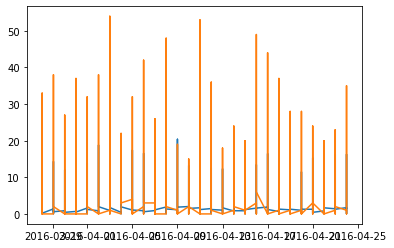

In [132]:
fig, ax = plt.subplots()
ax.plot(rf1_preds)
ax.plot(y_test)

In [133]:
mean_squared_error(rf1_preds, y_test, squared=False)

2.516124055908099

In [134]:
lgbm_1 = LGBMRegressor()
lgbm_1.fit(X_train, y_train)

LGBMRegressor()

In [135]:
lgbm_1.score(X_train, y_train)

0.4441915935639924

In [136]:
lgbm_1.score(X_test, y_test)

0.3387141416516706

In [137]:
lgbm_preds = lgbm_1.predict(X_test)

In [138]:
lgbm_preds = pd.Series(lgbm_preds).set_axis(y_test.index)

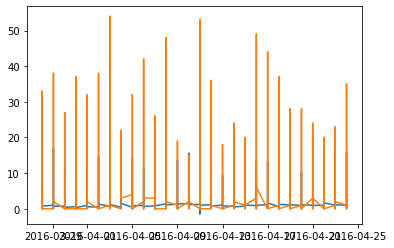

In [139]:
fig, ax = plt.subplots()
ax.plot(lgbm_preds)
ax.plot(y_test)

In [41]:
mean_squared_error(y_test, lgbm_preds, squared=False)

2.5197677064240955

In [140]:
xgb_1 = XGBRegressor()
xgb_1.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [141]:
xgb_1.score(X_train, y_train)

0.5598387836410585

In [142]:
xgb_1.score(X_test, y_test)

0.32589134106876716

In [143]:
xgb_preds = xgb_1.predict(X_test)

In [144]:
xgb_preds = pd.Series(xgb_preds).set_axis(y_test.index)

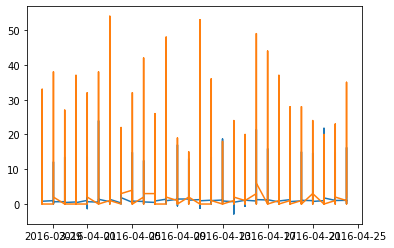

In [145]:
fig, ax = plt.subplots()
ax.plot(xgb_preds)
ax.plot(y_test)

In [146]:
mean_squared_error(y_test, xgb_preds, squared=False)

2.537359852163223

In [150]:
xgb_preds.min()

-2.8423312

In [151]:
lgbm_preds.min()

-1.4361684096340306